<a href="https://colab.research.google.com/github/WillKWL/Project-NBAGames/blob/master/source/1A_Games_load_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Does performance in pre-all star season predict playoff ranking? 
- Supervised offline binary classification task with imbalanced data
- Performance measure: average precision (AUPRC)
- Data source: https://www.nba.com/stats/teams/traditional/?sort=W&dir=-1&Season=2021-22&SeasonType=Regular%20Season 
- By predicting the probability of winning the championship based on mid-season (defined as regular season pre all-star game) performance of the NBA teams performance in the regular season before the All-Star game, 
  - As fans, we can tell whether our favorite team has a high chance to win this year during the middle of the season
  - As coaching staff and team manager, we can tell if we need to make a change in our roster to increase our chances

In [1]:
!pip install nba_api

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 125 kB 5.4 MB/s 
  Created wheel for nba-api: filename=nba_api-1.1.11-py3-none-any.whl size=251504 sha256=cb2875d4226d9b3f5fd5f737ef8a79a8af490eb61b3f913617e923cdf1a25a37
  Stored in directory: /root/.cache/pip/wheels/e3/f4/46/996128675381abc175e306642bae575d372dcf7efc4683e551
Successfully built nba-api


In [2]:
import pandas as pd
from nba_api.stats.endpoints import leaguedashteamstats, leaguedashplayerstats, leaguegamelog
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
import os
from tqdm import tqdm
import numpy as np
from zlib import crc32
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
import re
import copy

# Gather data with [nba api](https://github.com/swar/nba_api)
- stats adjusted per 100 posessions, instead of per game, to account for the different pace each team plays at
- [glossary](https://www.nba.com/stats/help/glossary/) for column names  
- extra data: [advanced team stats](https://www.nba.com/stats/teams/advanced/?sort=W&dir=-1) 



In [3]:
per_mode = 'Per100Possessions'

def get_team_table(measure_type, season, season_type, season_segment=""):
  # documentation: https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguedashteamstats.md
  return leaguedashteamstats.LeagueDashTeamStats(
      per_mode_detailed=per_mode, 
      measure_type_detailed_defense=measure_type,
      season=season, 
      season_type_all_star=season_type,
      season_segment_nullable=season_segment).get_data_frames()[0]

def get_boxscore_table(season, season_type):
  # documentation: https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/leaguegamelog.md
  return leaguegamelog.LeagueGameLog(
      season=season, 
      season_type_all_star=season_type,
      player_or_team_abbreviation='T').get_data_frames()[0]

In [ ]:
# season = '2021-22'
# boxscore_df = get_boxscore_table(season, "Playoffs")
# boxscore_df['HOME'] = boxscore_df['MATCHUP'].apply(lambda x: 0 if '@' in x else 1)
# boxscore_df['OUTCOME'] = np.where(boxscore_df['PLUS_MINUS'] > 0, 1, 0)
# playoff_teams = boxscore_df[['TEAM_ID', 'GAME_ID', 'OUTCOME']].groupby("GAME_ID").TEAM_ID.unique().reset_index()
# playoff_teams[['TEAM_ID', 'TEAM_ID_OPP']] = pd.DataFrame(playoff_teams['TEAM_ID'].tolist())
# playoff_teams2 = copy.deepcopy(playoff_teams)
# playoff_teams2[['TEAM_ID_OPP', 'TEAM_ID']] = playoff_teams2[['TEAM_ID', 'TEAM_ID_OPP']]
# playoff_games = pd.concat([playoff_teams, playoff_teams2]).sort_values("GAME_ID").merge(boxscore_df[['TEAM_ID', 'HOME', 'GAME_ID', 'OUTCOME']], on = ['GAME_ID', 'TEAM_ID'])
# playoff_games['SEASON'] = season
# playoff_games

In [ ]:
# season_df = get_team_table("Base", season, "Regular Season", "Pre All-Star")
# season_df

In [ ]:
# playoff_games.merge(season_df, on='TEAM_ID').merge(season_df, left_on='TEAM_ID_OPP', right_on='TEAM_ID', suffixes = ("", "_OPP"))

In [ ]:
# season_df = get_team_table("Base", season, "Regular Season", "Pre All-Star")
# list_of_measures = ["Advanced", "Misc", "Four Factors", "Scoring", "Opponent", "Defense"]
# for measure in list_of_measures:
#   try:
#     print(measure)
#     print(get_team_table(measure, season, "Regular Season", "Pre All-Star").columns.values)
#   except:
#     print(f"error at {measure}")

In [5]:
def season_vs_playoff(start_year, end_year):
  output = None
  season_list = [str(i) + '-' + str(i+1)[2:] for i in range(start_year, end_year)]
  with tqdm(total=len(season_list)) as pbar:
    for season in season_list:
       
      # df for team stats
      try:
        team_df = get_team_table("Base", season, "Regular Season", "Pre All-Star")
      except:
        print(f"error at Base {season} team")
      list_of_measures = ["Advanced", "Misc", "Four Factors", "Scoring", "Opponent", "Defense"]
      for measure in list_of_measures:
        try:
          result_df = get_team_table(measure, season, "Regular Season", "Pre All-Star")
          # print(f"{measure} success")
          team_df = team_df.merge(
            result_df[['TEAM_ID'] + result_df.columns.difference(team_df.columns).tolist()], # only keep the unique columns + TEAM_ID
            on = "TEAM_ID", how = "inner", suffixes = ("", "_y"))
        except: 
          print(f"error at {measure} {season} team")

      remaining_col = [x for x in team_df.columns if 
                      (re.search('_RANK$', x) is None) &   # remove columns ending in _RANK as we will clean our features later
                      (re.search('^E_\w+', x) is None)     # remove columns starting with E_ (unknown estimates provided by NBA)
                      ]
      try:
        team_df = team_df[remaining_col]
      except:
        print(f"error at team {season}")

      season_df = copy.deepcopy(team_df)

      try:
        # get winning and losing team in playoff games
        boxscore_df = get_boxscore_table(season, "Playoffs")
        # 1 = home, 0 = away
        boxscore_df['HOME'] = boxscore_df['MATCHUP'].apply(lambda x: 0 if '@' in x else 1)
        # 1 = win, 0 = loss
        boxscore_df['OUTCOME'] = np.where(boxscore_df['PLUS_MINUS'] > 0, 1, 0)
        playoff_teams = boxscore_df[['TEAM_ID', 'GAME_ID', 'OUTCOME']].groupby("GAME_ID").TEAM_ID.unique().reset_index()
        # get TEAM_ID and opponent_ID
        playoff_teams[['TEAM_ID', 'TEAM_ID_OPP']] = pd.DataFrame(playoff_teams['TEAM_ID'].tolist())
        playoff_teams2 = copy.deepcopy(playoff_teams)
        playoff_teams2[['TEAM_ID_OPP', 'TEAM_ID']] = playoff_teams2[['TEAM_ID', 'TEAM_ID_OPP']]
        playoff_games = pd.concat([playoff_teams, playoff_teams2]).sort_values("GAME_ID").merge(boxscore_df[['TEAM_ID', 'GAME_ID', 'GAME_DATE', 'MATCHUP', 'OUTCOME', 'HOME']], on = ['GAME_ID', 'TEAM_ID'])
        # merge to get team stats and opponent stats
        playoff_games['SEASON'] = season
        final_df = playoff_games.merge(season_df, on='TEAM_ID').merge(season_df, left_on='TEAM_ID_OPP', right_on='TEAM_ID', suffixes = ("", "_OPP"))
        
        # clean columns
        final_df = final_df[[x for x in final_df.columns if re.search('\w+\.\w+', x) is None]]

        output = pd.concat([output,final_df], axis = 0)
      except Exception as e:
        print(f"error at {season} playoff, {e}")

      pbar.update(1)
  
  return output

In [6]:
df = season_vs_playoff(start_year = 1996, end_year = 2022)
df

100%|██████████| 26/26 [02:00<00:00,  4.62s/it]


,GAME_ID,TEAM_ID,TEAM_ID_OPP,GAME_DATE,MATCHUP,OUTCOME,HOME,SEASON,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,TEAM_ID_OPP,TEAM_NAME_OPP,GP_OPP,W_OPP,L_OPP,W_PCT_OPP,MIN_OPP,FGM_OPP,FGA_OPP,FG_PCT_OPP,FG3M_OPP,FG3A_OPP,FG3_PCT_OPP,FTM_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,REB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PFD_OPP,PTS_OPP,PLUS_MINUS_OPP,CFID_OPP,CFPARAMS_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,NET_RATING_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,PACE_PER40_OPP,PIE_OPP,POSS_OPP,REB_PCT_OPP,TM_TOV_PCT_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3M_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FGM_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FTM_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP
0,0049600001,1610612766,1610612752,1997-04-24,CHH @ NYK,0,0,1996-97,Charlotte Hornets,48,29,19,0.604,53.4,39.3,85.6,0.459,7.7,18.2,0.424,20.4,26.7,0.763,12.4,31.0,43.4,26.4,16.4,7.7,4.4,5.1,23.6,0.2,106.6,-0.1,10,Charlotte Hornets,0.674,18.7,1.61,106.4,0.662,0.504,0.2,106.6,0.316,90.00,75.00,0.512,4333,0.493,0.164,0.548,17.1,12.3,18.3,45.6,13.5,11.2,18.1,40.3,0.312,0.496,0.275,0.338,0.154,0.630,0.853,0.674,0.788,0.212,0.592,0.214,0.217,0.105,0.191,0.170,0.378,0.370,0.147,0.326,23.7,5.1,4.4,31.3,18.5,6.8,0.368,89.6,41.0,0.458,24.7,17.8,0.723,14.3,24.3,23.6,106.7,45.6,7.2,15.4,1610612752,New York Knicks,48,34,14,0.708,52.0,38.1,82.9,0.459,6.2,17.0,0.368,19.7,26.3,0.750,13.5,32.7,46.3,23.7,20.0,8.7,5.4,3.9,26.9,0.1,102.1,3.8,10,New York Knicks,0.622,17.0,1.18,98.2,0.697,0.497,3.9,102.1,0.335,92.40,77.00,0.536,4452,0.520,0.200,0.541,13.6,8.7,20.4,35.3,15.3,12.6,20.7,42.3,0.318,0.466,0.389,0.303,0.190,0.593,0.773,0.622,0.795,0.205,0.623,0.209,0.183,0.123,0.193,0.202,0.414,0.407,0.227,0.378,20.9,3.9,5.4,29.3,18.4,6.6,0.360,81.0,34.4,0.425,31.5,22.9,0.726,11.7,24.2,26.9,98.3,41.0,9.9,19.0
1,0049600010,1610612766,1610612752,1997-04-26,CHH @ NYK,0,0,1996-97,Charlotte Hornets,48,29,19,0.604,53.4,39.3,85.6,0.459,7.7,18.2,0.424,20.4,26.7,0.763,12.4,31.0,43.4,26.4,16.4,7.7,4.4,5.1,23.6,0.2,106.6,-0.1,10,Charlotte Hornets,0.674,18.7,1.61,106.4,0.662,0.504,0.2,106.6,0.316,90.00,75.00,0.512,4333,0.493,0.164,0.548,17.1,12.3,18.3,45.6,13.5,11.2,18.1,40.3,0.312,0.496,0.275,0.338,0.154,0.630,0.853,0.674,0.788,0.212,0.592,0.214,0.217,0.105,0.191,0.170,0.378,0.370,0.147,0.326,23.7,5.1,4.4,31.3,18.5,6.8,0.368,89.6,41.0,0.458,24.7,17.8,0.723,14.3,24.3,23.6,106.7,45.6,7.2,15.4,1610612752,New York Knicks,48,34,14,0.708,52.0,38.1,82.9,0.459,6.2,17.0,0.368,19.7,26.3,0.750,13.5,32.7,46.3,23.7,20.0,8.7,5.4,3.9,26.9,0.1,102.1,3.8,10,New York Knicks,0.622,17.0,1.18,98.2,0.697,0.497,3.9,102.1,0.335,92.40,77.00,0.536,4452,0.520,0.200

In [ ]:
# df_2002 = season_vs_playoff(start_year = 2002, end_year = 2003)
# for team_id in df_2002.TEAM_ID.unique():
#   df.loc[(df.TEAM_ID == team_id) & (df.SEASON == '2002-03')] = df_2002.loc[(df_2002.TEAM_ID == team_id)]

100%|██████████| 1/1 [00:00<00:00,  1.04it/s]


In [8]:
df.to_csv('nba_pre_all_star_vs_playoff_games.csv', index = False)
# download local copy to upload to github
from google.colab import files
files.download("nba_pre_all_star_vs_playoff_games.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
# pull from github
df = pd.read_csv('https://github.com/WillKWL/PublicData/raw/main/raw/nba_pre_all_star_vs_playoff_games.csv')
df

,GAME_ID,TEAM_ID,TEAM_ID_OPP,GAME_DATE,MATCHUP,OUTCOME,HOME,SEASON,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,TEAM_ID_OPP.1,TEAM_NAME_OPP,GP_OPP,W_OPP,L_OPP,W_PCT_OPP,MIN_OPP,FGM_OPP,FGA_OPP,FG_PCT_OPP,FG3M_OPP,FG3A_OPP,FG3_PCT_OPP,FTM_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,REB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PFD_OPP,PTS_OPP,PLUS_MINUS_OPP,CFID_OPP,CFPARAMS_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,NET_RATING_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,PACE_PER40_OPP,PIE_OPP,POSS_OPP,REB_PCT_OPP,TM_TOV_PCT_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3M_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FGM_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FTM_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP
0,49600001,1610612766,1610612752,1997-04-24,CHH @ NYK,0,0,1996-97,Charlotte Hornets,48,29,19,0.604,53.4,39.3,85.6,0.459,7.7,18.2,0.424,20.4,26.7,0.763,12.4,31.0,43.4,26.4,16.4,7.7,4.4,5.1,23.6,0.2,106.6,-0.1,10,Charlotte Hornets,0.674,18.7,1.61,106.4,0.662,0.504,0.2,106.6,0.316,90.00,75.00,0.512,4333,0.493,0.164,0.548,17.1,12.3,18.3,45.6,13.5,11.2,18.1,40.3,0.312,0.496,0.275,0.338,0.154,0.630,0.853,0.674,0.788,0.212,0.592,0.214,0.217,0.105,0.191,0.170,0.378,0.370,0.147,0.326,23.7,5.1,4.4,31.3,18.5,6.8,0.368,89.6,41.0,0.458,24.7,17.8,0.723,14.3,24.3,23.6,106.7,45.6,7.2,15.4,1610612752,New York Knicks,48,34,14,0.708,52.0,38.1,82.9,0.459,6.2,17.0,0.368,19.7,26.3,0.750,13.5,32.7,46.3,23.7,20.0,8.7,5.4,3.9,26.9,0.1,102.1,3.8,10,New York Knicks,0.622,17.0,1.18,98.2,0.697,0.497,3.9,102.1,0.335,92.40,77.00,0.536,4452,0.520,0.200,0.541,13.6,8.7,20.4,35.3,15.3,12.6,20.7,42.3,0.318,0.466,0.389,0.303,0.190,0.593,0.773,0.622,0.795,0.205,0.623,0.209,0.183,0.123,0.193,0.202,0.414,0.407,0.227,0.378,20.9,3.9,5.4,29.3,18.4,6.6,0.360,81.0,34.4,0.425,31.5,22.9,0.726,11.7,24.2,26.9,98.3,41.0,9.9,19.0
1,49600010,1610612766,1610612752,1997-04-26,CHH @ NYK,0,0,1996-97,Charlotte Hornets,48,29,19,0.604,53.4,39.3,85.6,0.459,7.7,18.2,0.424,20.4,26.7,0.763,12.4,31.0,43.4,26.4,16.4,7.7,4.4,5.1,23.6,0.2,106.6,-0.1,10,Charlotte Hornets,0.674,18.7,1.61,106.4,0.662,0.504,0.2,106.6,0.316,90.00,75.00,0.512,4333,0.493,0.164,0.548,17.1,12.3,18.3,45.6,13.5,11.2,18.1,40.3,0.312,0.496,0.275,0.338,0.154,0.630,0.853,0.674,0.788,0.212,0.592,0.214,0.217,0.105,0.191,0.170,0.378,0.370,0.147,0.326,23.7,5.1,4.4,31.3,18.5,6.8,0.368,89.6,41.0,0.458,24.7,17.8,0.723,14.3,24.3,23.6,106.7,45.6,7.2,15.4,1610612752,New York Knicks,48,34,14,0.708,52.0,38.1,82.9,0.459,6.2,17.0,0.368,19.7,26.3,0.750,13.5,32.7,46.3,23.7,20.0,8.7,5.4,3.9,26.9,0.1,102.1,3.8,10,New York Knicks,0.622,17.0,1.18,98.2,0.697,0.497,3.9,102.1,0.335,92.40,77.00,0.536,4452,0.520,0.200,0

In [10]:
pd.DataFrame(df.dtypes).T

,GAME_ID,TEAM_ID,TEAM_ID_OPP,GAME_DATE,MATCHUP,OUTCOME,HOME,SEASON,TEAM_NAME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,CFPARAMS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,TEAM_ID_OPP.1,TEAM_NAME_OPP,GP_OPP,W_OPP,L_OPP,W_PCT_OPP,MIN_OPP,FGM_OPP,FGA_OPP,FG_PCT_OPP,FG3M_OPP,FG3A_OPP,FG3_PCT_OPP,FTM_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,REB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PFD_OPP,PTS_OPP,PLUS_MINUS_OPP,CFID_OPP,CFPARAMS_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,NET_RATING_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,PACE_PER40_OPP,PIE_OPP,POSS_OPP,REB_PCT_OPP,TM_TOV_PCT_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3M_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FGM_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FTM_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP
0,int64,int64,int64,object,object,int64,int64,object,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [11]:
df.describe()

,GAME_ID,TEAM_ID,TEAM_ID_OPP,OUTCOME,HOME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,CFID,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,TEAM_ID_OPP.1,GP_OPP,W_OPP,L_OPP,W_PCT_OPP,MIN_OPP,FGM_OPP,FGA_OPP,FG_PCT_OPP,FG3M_OPP,FG3A_OPP,FG3_PCT_OPP,FTM_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,REB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PFD_OPP,PTS_OPP,PLUS_MINUS_OPP,CFID_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,NET_RATING_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,PACE_PER40_OPP,PIE_OPP,POSS_OPP,REB_PCT_OPP,TM_TOV_PCT_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3M_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FGM_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FTM_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP
count,4.210000e+03,4.210000e+03,4.210000e+03,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.00000,4210.000000,4210.00000,4210.000000,4210.000000,4210.000000,4210.00000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.00000,4210.000000,4210.000000,4210.0,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4.210000e+03,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.00000,4210.000000,4210.00000,4210.000000,4210.000000,4210.000000,4210.00000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.00000,4210.000000,4210.000000,4210.0,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.000000,4210.0

# Remove outlier rows by GP

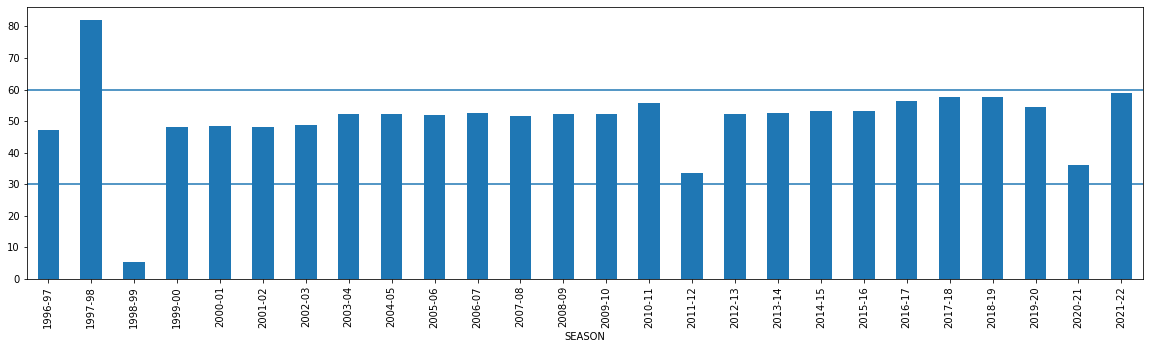

In [12]:
# consider removing outlier in terms of games played 
# since those records are not representative samples of mid-season performance
# 1997-98: 82 games played = whole season but not mid-season, 
  # all-star game was held in Feb (Kobe's debut for youngest all-star player)
  # season lasted from Oct to Apr
# 1998-89: see 1998 NBA lockout
  # < 10 games played = too small of a sample size to gauge mid-season performance
# 2011-12: see 2011 NBA lockout
# 2020-21: see postponed season due to COVID-19
df.groupby('SEASON').GP.mean().plot(kind='bar')
plt.axhline(30)
plt.axhline(60)

In [13]:
# cannot pass this in sklearn pipeline so let's do it on dataset level
# drop any season with games played <= 30 or >= 60 such that we have a large enough sample to gauge mid-season performance
df = df.loc[(df.GP >= 30) & (df.GP <= 60)]

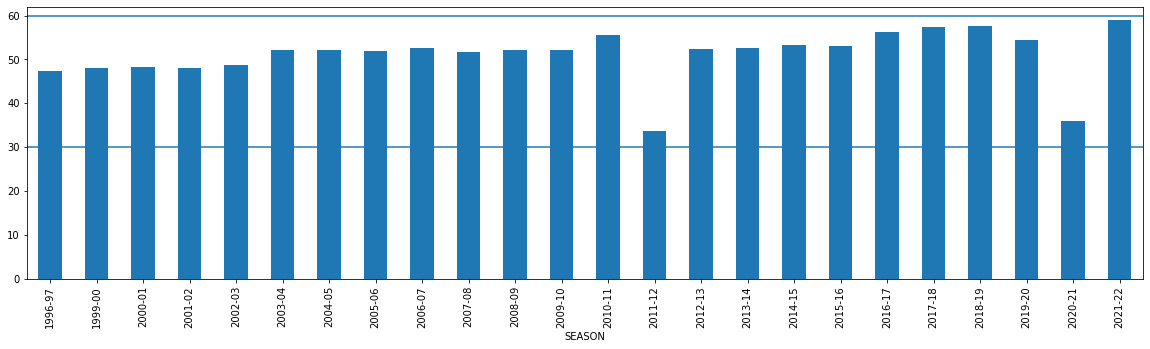

In [14]:
# now fixed
df.groupby('SEASON').GP.mean().plot(kind='bar')
plt.axhline(30)
plt.axhline(60)

In [39]:
# fix datatypes
df.loc[:, 'GAME_ID'] = df['GAME_ID'].astype(str)
df.loc[:, 'TEAM_ID'] = df['TEAM_ID'].astype(str)
df.loc[:, 'TEAM_ID_OPP'] = df['TEAM_ID_OPP'].astype(str)
df.loc[:, 'GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])
df.loc[:, 'MATCHUP'] = df['MATCHUP'].astype(str)
df.loc[:, 'CFID'] = df['CFID'].astype(str)
df.loc[:, 'CFID_OPP'] = df['CFID_OPP'].astype(str)
df.loc[:, 'SEASON'] = df['SEASON'].astype('category')


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [40]:
pd.DataFrame(df.select_dtypes(include=np.number).dtypes).T

,OUTCOME,HOME,GP,W,L,W_PCT,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,OREB,DREB,REB,AST,TOV,STL,BLK,BLKA,PF,PFD,PTS,PLUS_MINUS,AST_PCT,AST_RATIO,AST_TO,DEF_RATING,DREB_PCT,EFG_PCT,NET_RATING,OFF_RATING,OREB_PCT,PACE,PACE_PER40,PIE,POSS,REB_PCT,TM_TOV_PCT,TS_PCT,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_OFF_TOV,OPP_PTS_PAINT,PTS_2ND_CHANCE,PTS_FB,PTS_OFF_TOV,PTS_PAINT,FTA_RATE,OPP_EFG_PCT,OPP_FTA_RATE,OPP_OREB_PCT,OPP_TOV_PCT,PCT_AST_2PM,PCT_AST_3PM,PCT_AST_FGM,PCT_FGA_2PT,PCT_FGA_3PT,PCT_PTS_2PT,PCT_PTS_2PT_MR,PCT_PTS_3PT,PCT_PTS_FB,PCT_PTS_FT,PCT_PTS_OFF_TOV,PCT_PTS_PAINT,PCT_UAST_2PM,PCT_UAST_3PM,PCT_UAST_FGM,OPP_AST,OPP_BLK,OPP_BLKA,OPP_DREB,OPP_FG3A,OPP_FG3M,OPP_FG3_PCT,OPP_FGA,OPP_FGM,OPP_FG_PCT,OPP_FTA,OPP_FTM,OPP_FT_PCT,OPP_OREB,OPP_PF,OPP_PFD,OPP_PTS,OPP_REB,OPP_STL,OPP_TOV,GP_OPP,W_OPP,L_OPP,W_PCT_OPP,MIN_OPP,FGM_OPP,FGA_OPP,FG_PCT_OPP,FG3M_OPP,FG3A_OPP,FG3_PCT_OPP,FTM_OPP,FTA_OPP,FT_PCT_OPP,OREB_OPP,DREB_OPP,REB_OPP,AST_OPP,TOV_OPP,STL_OPP,BLK_OPP,BLKA_OPP,PF_OPP,PFD_OPP,PTS_OPP,PLUS_MINUS_OPP,AST_PCT_OPP,AST_RATIO_OPP,AST_TO_OPP,DEF_RATING_OPP,DREB_PCT_OPP,EFG_PCT_OPP,NET_RATING_OPP,OFF_RATING_OPP,OREB_PCT_OPP,PACE_OPP,PACE_PER40_OPP,PIE_OPP,POSS_OPP,REB_PCT_OPP,TM_TOV_PCT_OPP,TS_PCT_OPP,OPP_PTS_2ND_CHANCE_OPP,OPP_PTS_FB_OPP,OPP_PTS_OFF_TOV_OPP,OPP_PTS_PAINT_OPP,PTS_2ND_CHANCE_OPP,PTS_FB_OPP,PTS_OFF_TOV_OPP,PTS_PAINT_OPP,FTA_RATE_OPP,OPP_EFG_PCT_OPP,OPP_FTA_RATE_OPP,OPP_OREB_PCT_OPP,OPP_TOV_PCT_OPP,PCT_AST_2PM_OPP,PCT_AST_3PM_OPP,PCT_AST_FGM_OPP,PCT_FGA_2PT_OPP,PCT_FGA_3PT_OPP,PCT_PTS_2PT_OPP,PCT_PTS_2PT_MR_OPP,PCT_PTS_3PT_OPP,PCT_PTS_FB_OPP,PCT_PTS_FT_OPP,PCT_PTS_OFF_TOV_OPP,PCT_PTS_PAINT_OPP,PCT_UAST_2PM_OPP,PCT_UAST_3PM_OPP,PCT_UAST_FGM_OPP,OPP_AST_OPP,OPP_BLK_OPP,OPP_BLKA_OPP,OPP_DREB_OPP,OPP_FG3A_OPP,OPP_FG3M_OPP,OPP_FG3_PCT_OPP,OPP_FGA_OPP,OPP_FGM_OPP,OPP_FG_PCT_OPP,OPP_FTA_OPP,OPP_FTM_OPP,OPP_FT_PCT_OPP,OPP_OREB_OPP,OPP_PF_OPP,OPP_PFD_OPP,OPP_PTS_OPP,OPP_REB_OPP,OPP_STL_OPP,OPP_TOV_OPP
0,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [41]:
pd.DataFrame(df.select_dtypes(exclude=np.number).dtypes).T

,GAME_ID,TEAM_ID,TEAM_ID_OPP,GAME_DATE,MATCHUP,SEASON,TEAM_NAME,CFID,CFPARAMS,TEAM_NAME_OPP,CFID_OPP,CFPARAMS_OPP
0,object,object,object,datetime64[ns],object,category,object,object,object,object,object,object


# Check numeric columns

In [42]:
# no identifier included here
sorted(df.select_dtypes(include=np.number).columns.values)

['AST',
 'AST_OPP',
 'AST_PCT',
 'AST_PCT_OPP',
 'AST_RATIO',
 'AST_RATIO_OPP',
 'AST_TO',
 'AST_TO_OPP',
 'BLK',
 'BLKA',
 'BLKA_OPP',
 'BLK_OPP',
 'DEF_RATING',
 'DEF_RATING_OPP',
 'DREB',
 'DREB_OPP',
 'DREB_PCT',
 'DREB_PCT_OPP',
 'EFG_PCT',
 'EFG_PCT_OPP',
 'FG3A',
 'FG3A_OPP',
 'FG3M',
 'FG3M_OPP',
 'FG3_PCT',
 'FG3_PCT_OPP',
 'FGA',
 'FGA_OPP',
 'FGM',
 'FGM_OPP',
 'FG_PCT',
 'FG_PCT_OPP',
 'FTA',
 'FTA_OPP',
 'FTA_RATE',
 'FTA_RATE_OPP',
 'FTM',
 'FTM_OPP',
 'FT_PCT',
 'FT_PCT_OPP',
 'GP',
 'GP_OPP',
 'HOME',
 'L',
 'L_OPP',
 'MIN',
 'MIN_OPP',
 'NET_RATING',
 'NET_RATING_OPP',
 'OFF_RATING',
 'OFF_RATING_OPP',
 'OPP_AST',
 'OPP_AST_OPP',
 'OPP_BLK',
 'OPP_BLKA',
 'OPP_BLKA_OPP',
 'OPP_BLK_OPP',
 'OPP_DREB',
 'OPP_DREB_OPP',
 'OPP_EFG_PCT',
 'OPP_EFG_PCT_OPP',
 'OPP_FG3A',
 'OPP_FG3A_OPP',
 'OPP_FG3M',
 'OPP_FG3M_OPP',
 'OPP_FG3_PCT',
 'OPP_FG3_PCT_OPP',
 'OPP_FGA',
 'OPP_FGA_OPP',
 'OPP_FGM',
 'OPP_FGM_OPP',
 'OPP_FG_PCT',
 'OPP_FG_PCT_OPP',
 'OPP_FTA',
 'OPP_FTA_OPP',
 'OPP_F

# Train test split with unique identifier = GAME_ID + SEASON
- hashing unique identifier
- alternative: stratified sampling by season

In [43]:
# unique id = GAME id + season
df.loc[:, 'UNIQUE_ID'] = df['GAME_ID'].astype(str) + df['SEASON'].str.replace('-','')

In [44]:
# instead of train-test_split by random shuffling, hash the unique identifier for train-test split
# slight modification to the technique from Hands On Machine Learning by Aurélien Géron
def split_data_with_id_hash(data, test_ratio, id_column):
  ids = data[id_column]
  threshold = np.quantile(ids.apply(lambda x: crc32(np.int64(x))), test_ratio) # instead of using test_ratio * 2**32 as the threshold, this is more accurate
  in_test_set = ids.apply(lambda x: crc32(np.int64(x)) < threshold) 
  return data.loc[~in_test_set], data.loc[in_test_set]

In [45]:
train_set, test_set = split_data_with_id_hash(df, 0.2, "UNIQUE_ID")

In [46]:
print(f"size of full dataset: {df.shape}")
print(f"size of train dataset: {train_set.shape}")
print(f"size of test dataset: {test_set.shape}")
print(f"train-test ratio: {train_set.shape[0] / df.shape[0]:0.2} / {test_set.shape[0] / df.shape[0]:0.2}")

size of full dataset: (3931, 195)
size of train dataset: (3145, 195)
size of test dataset: (786, 195)
train-test ratio: 0.8 / 0.2


In [47]:
# save to google drive
train_set.to_pickle('nba_pre_all_star_vs_playoff_games_train_comprehensive.pkl')
test_set.to_pickle('nba_pre_all_star_vs_playoff_games_test_comprehensive.pkl')

# download local copy to push to github
from google.colab import files
files.download("nba_pre_all_star_vs_playoff_games_train_comprehensive.pkl")
files.download("nba_pre_all_star_vs_playoff_games_test_comprehensive.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>